In [1]:
import os
import onnxruntime as ort
import numpy as np
from hiq.framework.onnxruntime import OrtHiQLatency

driver = OrtHiQLatency()

here = os.path.dirname(os.path.realpath("__file__"))

if not os.path.exists(f"{here}/alexnet.onnx"):
    import torch
    import torchvision
    dummy_input = torch.randn(10, 3, 224, 224, device="cpu")
    model = torchvision.models.alexnet(pretrained=True)
    input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
    output_names = [ "output1" ]
    _ = torch.onnx.export(model,
                    dummy_input,
                    f"{here}/alexnet.onnx",
                    verbose=True,
                    input_names=input_names,
                    output_names=output_names)
ort_session = ort.InferenceSession(f"{here}/alexnet.onnx")
for _ in range(3):
    _ = ort_session.run(
        None,
        {"actual_input_1": np.random.randn(10, 3, 224, 224).astype(np.float32)},
    )

In [2]:
from hiq import KEY_LATENCY
t = driver.get_metrics(metrics_key=KEY_LATENCY)[0]
t.show()

[ 1649544212.805 -  1649544213.608]  [100.00%] 🟢_root_time(0.8032)
                                                 [OH:476us]
[ 1649544212.805 -  1649544213.330]  [ 65.41%]    |_ort_session(0.5253)
[ 1649544212.805 -  1649544212.805]  [  0.00%]    |  |___sess_init(0.0000)
[ 1649544212.805 -  1649544213.330]  [ 65.39%]    |  l___create_inference_session(0.5252)
[ 1649544213.371 -  1649544213.424]  [  6.58%]    |___ort_run(0.0528)
[ 1649544213.464 -  1649544213.516]  [  6.43%]    |___ort_run(0.0516)
[ 1649544213.556 -  1649544213.608]  [  6.43%]    l___ort_run(0.0516)



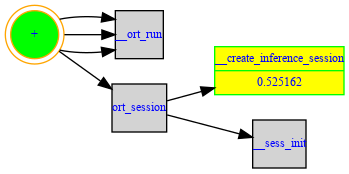

In [3]:
from IPython.display import Image
Image(t.to_img())


'/tmp/tim_i49q906gfs31.png'

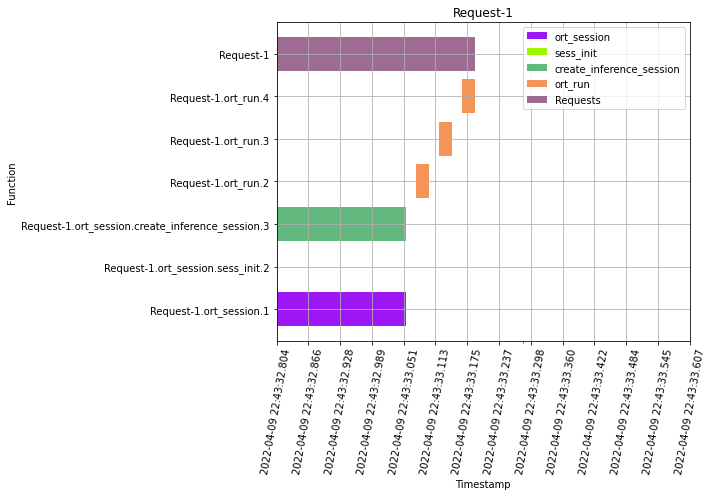

In [4]:
from hiq.utils import create_gantt_chart_time
create_gantt_chart_time(t.repr())